# Detect fDOM Phantom Peaks

## Rules for fDOM Phantom Peaks

Upward peak where: 
- There is a corresponding preceding or succeeding stage rise in a given interval
- The peak has a prominence to basewidth ratio above a certain threshold
- The peak is not between Sept 15 - Nov 1

In [9]:
# Import libraries and data 
import scipy.io as sio
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sn
import scipy.ndimage as ndimage
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pickle
import numpy as np
from scipy.signal import find_peaks
from os.path import dirname, join as pjoin
import datetime
import csv
import math
import Tools.data_processing as dp
import Tools.data_movement as dm 
from Tools.auxiliary_functions import get_candidates, detect_flat_plat, detect_stage_rises

fDOM_data = dm.read_in_preprocessed_timeseries('Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv')
stage_data = dm.read_in_preprocessed_timeseries('Data/converted_data/julian_format/stage_10.1.11-1.1.19.csv')
turb_data = dm.read_in_preprocessed_timeseries('Data/converted_data/julian_format/turbidity_raw_10.1.2011_9.4.2020.csv')
stage_data = dp.align_stage_to_fDOM(fDOM_data, stage_data)
fDOM_data_unsmoothed = copy.deepcopy(fDOM_data)
# fDOM_data = fDOM_data_unsmoothed

# Smooth fDOM data with low pass filter

In [10]:
def low_pass_filter(data, window_len):
    """
    (2 * window_len) + 1 is the size of the window that determines the values that 
    influence the current measurement (middle of window)
    """
    kernel = np.lib.pad(np.linspace(1,3,window_len), (0,window_len -1), 'reflect')
    kernel = np.divide(kernel, np.sum(kernel))
    return ndimage.convolve(data, kernel)

smoothed_signal = low_pass_filter(fDOM_data[:,1], 7)
fDOM_data = np.column_stack((fDOM_data[:,0],smoothed_signal))

### Detect and process stage rises

In [11]:
# Get stage rises
s_indices = detect_stage_rises(stage_data[:,1])

# Process stage rises so that each index displays distance to next stage rise in positive and negative direction
y = s_indices.shape[0] -1 
s_indexed = np.zeros((s_indices.shape[0],2))
x_count = -1 
y_count = -1
for x in range(s_indices.shape[0]):
    # X Block 
    
    # When x encounters first stage rise, start x counter
    if x_count == -1 and s_indices[x] == 1:
        x_count = 0
    if x_count != -1:
        if s_indices[x] == 1:
            x_count = 0
            s_indexed[x,0] = x_count
        else:
            x_count += 1
            s_indexed[x,0] = x_count
    else:
        s_indexed[x,0] = -1
            
    # Y Block
    if y_count == -1 and s_indices[y] == 1:
        y_count = 0
    if y_count != -1:
        if s_indices[y] == 1:
            y_count = 0
            s_indexed[y,1] = y_count
        else:
            y_count += 1
            s_indexed[y,1] = y_count
    else: 
        s_indexed[y,1] = -1
        
    y-=1

## Get fDOM PP candidate set

There are areas of missing data that cause peaks to be detected where there are no peaks

In [12]:
candidate_params = {'prom' : [3,None],
                    'width': [None, None],
                    'wlen' : 200,
                    'dist' : 1,
                    'rel_h': .6}

# These are a few manually entered ranges where data is missing and erroneously 
# causes a peak to be detected... for now we just remove the fake peaks detected in these ranges
remove_ranges = [[17816, 17849], [108170,108200],[111364, 111381]]

def isInRange(indx):
    for rng in remove_ranges:
        if rng[0] <= indx and indx <= rng[1]:
            return True
    return False 

peaks, props = get_candidates(fDOM_data, candidate_params)

cands = [[peak, math.floor(props['left_ips'][i]), math.ceil(props['right_ips'][i]),s_indexed[peak,0], s_indexed[peak,1] ,props['prominences'][i]] for i,peak in enumerate(peaks)]

# Remove erroneously detected peaks
temp = []
for peak in cands:
    if not(isInRange(peak[0])):
        temp.append(peak)
cands = copy.deepcopy(temp)


## Import ground truth labels

In [13]:
# Import ground truth values 
truth_fname = 'Data/labeled_data/ground_truths/fDOM/fDOM_PP/julian_time/fDOM_PP_0k-300k.csv'

with open(truth_fname, 'r', newline = '') as f:
    
        reader = csv.reader(f, delimiter = ',')
        # truth entries in form: ['timestamp_of_peak', 'value_of_peak','label_of_peak','idx_of_peak']
        next(reader)
        truths = [[float(row[0]), float(row[1]), row[2], int(row[3])] for row in reader] 
        f.close()   

assert(len(truths) == len(cands))
# PP: 73, NPP: 441

## Avoid Repeated Work 

Avoid repeated work by adding a boolean attribute to each candidate indictating whether or not 
it falls between Sept15 - Nov1.  FL == 'Fall', NFL = 'Not Fall'

In [14]:
for cand in cands: 
    dt = dp.julian_to_datetime(fDOM_data[cand[0],0])
    if (dt.month == 10) or (dt.month == 9 and dt.day >= 20):
        cand.append('FL')
    else: 
        cand.append('NFL')

## Define helper functions and set of training parameters, create training/testing splits

In [15]:
# Define Hyperparameter ranges and training parameters and helper function
iterations = 7000
num_splits = 5

x_bounds = (0, 100)
y_bounds = (0, 100)

ratio_threshold_range = (0, 20)

accumulated_test_metrics = {}

accumulated_test_results = {}

accumulated_best_params = {}

accumulated_cfmxs = {}

train_test_split_indices = TimeSeriesSplit(num_splits).split(cands)

def classify_candidate_peaks(peaks, params):
    results = []
    for peak in peaks:
        
        # Peak is not near stage rise
        stage_rise_condition = not (peak[3] != -1 and peak[3] <= params['x']) or (peak[4] !=-1 and peak[4] <= params['y'])
        # Peak is not in fall 
        fall_range_condition = peak[6] == 'NFL'
        # Peak has a large enough prominence/basewidth ratio 
        pbwr = peak[5] / abs(peak[1] - peak[2])
        pbwr_condition = pbwr > params['ratio_threshold']
                
        if stage_rise_condition and fall_range_condition and pbwr_condition: 
            results.append([peak[0], 'PP'])
#             print(f'st: {stage_rise_condition} fl: {fall_range_condition} r:{pbwr_condition}')
        else: 
            results.append([peak[0], 'NPP'])
    return results

def label_positives_negatives(predictions, truths):
    TP = TN = FP = FN = 0
    results = []
    
    for i in range(len(predictions)):
        prediction = predictions[i][1]
        truth = truths[i][2]
        
        if prediction == 'NPP':
            if truth == 'NPP':
                TN +=1
                results.append(predictions[i].append('TN'))
            else: 
                FN+=1
                results.append(predictions[i].append('FN'))
        else:
            if truth == 'NPP':
                FP+=1
                results.append(predictions[i].append('FP'))
            else: #TODO: Comeback and evaluate if this makes sense: Algo could predict PP because X/Y was not optimal, while truth was PPP because of interference
                TP+=1
                results.append(predictions[i].append('TP'))
        
    return (TP,TN,FP,FN,results)
    

## Nested Cross Validation for fDOM PP

Num Pos in Test 4
Split:  1
 700/7000  1400/7000  2100/7000  2800/7000  3500/7000  4200/7000  4900/7000  5600/7000  6300/7000 
 [[76  5]
 [ 0  4]]

Split: 1  F1: 0.6154 BA: 0.9691  Params: {'x': 68, 'y': 0, 'ratio_threshold': 0.07692846878806447}  TP: 4 TN: 76 FP: 5 FN: 0  Time: 0:00:00.601168
Num Pos in Test 0
Num Pos in Test 1
Num Pos in Test 9
Split:  2
 700/7000  1400/7000  2100/7000  2800/7000  3500/7000  4200/7000  4900/7000  5600/7000  6300/7000 
 [[72  4]
 [ 3  6]]

Split: 2  F1: 0.6316 BA: 0.8070  Params: {'x': 71, 'y': 1, 'ratio_threshold': 0.06170612352419891}  TP: 6 TN: 72 FP: 4 FN: 3  Time: 0:00:02.256888
Num Pos in Test 29
Split:  3
 700/7000  1400/7000  2100/7000  2800/7000  3500/7000  4200/7000  4900/7000  5600/7000  6300/7000 
 [[55  1]
 [ 0 29]]

Split: 3  F1: 0.9831 BA: 0.9911  Params: {'x': 53, 'y': 9, 'ratio_threshold': 0.04047599214441089}  TP: 29 TN: 55 FP: 1 FN: 0  Time: 0:00:02.849075
Mean Test F1:  0.7433381367368878
Mean Test BA:  0.9224082583000711
Mean Test

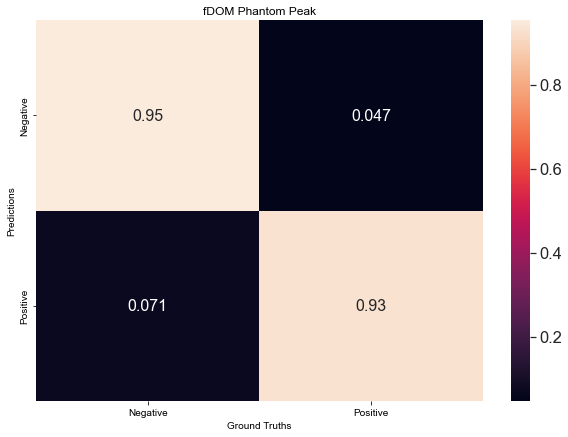

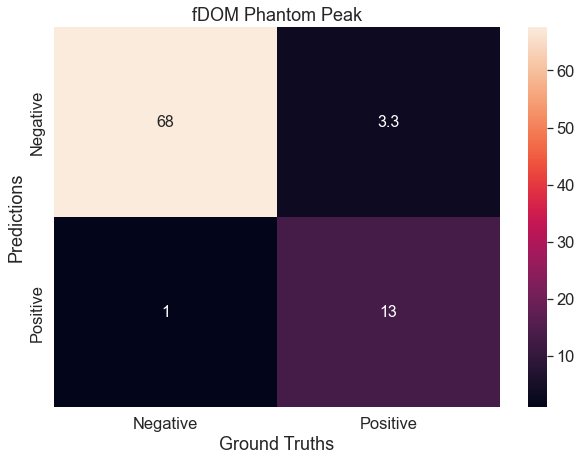

In [16]:
overall_start = datetime.datetime.now()

split = 1

for train_val_indices, test_indices in train_test_split_indices:
    X_train, y_train = [cands[i] for i in train_val_indices], [truths[i] for i in train_val_indices]
    X_test, y_test = [cands[i] for i in test_indices], [truths[i] for i in test_indices]
    print(f'Num Pos in Test {len(list(filter(lambda x: x[2] == "PP", y_test)))}')
    num_pos= len(list(filter(lambda x: x[2] == "PP", y_test)))
    if num_pos > 1: 
    
        max_fold_metric = 0 
        max_result = None 

        print("Split: ",split)

        split_start = datetime.datetime.now()

        for iteration in range(iterations):

            # Random grid search for hyperparams 
            params = {}

            params['x'] = np.random.randint(x_bounds[0], x_bounds[1]+1)
            params['y'] = np.random.randint(y_bounds[0], y_bounds[1]+1)
            params['ratio_threshold'] = np.random.uniform(ratio_threshold_range[0], ratio_threshold_range[1])

            predictions = classify_candidate_peaks(X_train, params)

            TP,TN,FP,FN,results = label_positives_negatives(predictions, y_train)

            TPR = 0 if TP == FN == 0 else TP/(TP + FN)
            TNR = TN/(TN + FP)

            bal_acc = (TPR + TNR)/2 

            f1_score = 0 if TP == FP == FN == 0 else (2 * TP)/((2 * TP) + FP + FN)

            acc = bal_acc
            if iteration and iteration % int(iterations/10) == 0: print(" {}/{} ".format(iteration, iterations), end = "")
            if acc > max_fold_metric: 
                max_fold_metric = acc
                max_result = copy.deepcopy(results)
                best_params = copy.deepcopy(params)
        # Test best parameters on testing data 
        test_predictions = classify_candidate_peaks(X_test, best_params)
        TP,TN,FP,FN,results = label_positives_negatives(test_predictions, y_test)

        cfmx = confusion_matrix([row[2] for row in y_test],[row[1] for row in test_predictions], labels = ['NPP', 'PP'])
        print("\n",cfmx)
        accumulated_cfmxs[split] = copy.deepcopy(cfmx)

        TPR = 0 if TP == FN == 0 else TP/(TP + FN)
        TNR = TN/(TN + FP)

        precision = 0 if TP == FP == 0 else TP/(TP + FP)

        bal_acc = (TPR + TNR)/2 

        f1_score = 0 if TP == FP == FN == 0 else (2 * TP)/((2 * TP) + FP + FN)

        print('\nSplit: {}  F1: {:.4f} BA: {:.4f}  Params: {}  TP: {} TN: {} FP: {} FN: {}  Time: {}'.format(split, f1_score, bal_acc, best_params, TP, TN, FP, FN, datetime.datetime.now() - split_start))
        accumulated_test_metrics[split] = {'f1': f1_score, 'ba' : bal_acc, 'tpr': TPR, 'tnr' : TNR, 'precision': precision} # Record test metrics of each split
        accumulated_test_results[split] = copy.deepcopy(results) # Record test results (FP,FN,TP,TN for each datapoint) for each split
        accumulated_best_params[split] = copy.deepcopy(best_params) # Record params uses in testing for each split

        split+=1

# Display Resuls 
mean_f1 = 0
mean_ba = 0 
mean_sensitivity = 0
mean_specificity = 0 
mean_precision = 0

for key in accumulated_test_metrics:
    metrics = accumulated_test_metrics[key]
    
    mean_f1+=metrics['f1']
    mean_ba+=metrics['ba']
    mean_sensitivity += metrics['tpr']
    mean_specificity += metrics['tnr']
    mean_precision += metrics['precision']

print("Mean Test F1: ", mean_f1/len(accumulated_test_metrics))
print("Mean Test BA: ", mean_ba/len(accumulated_test_metrics))
print("Mean Test TPR: ", mean_sensitivity/len(accumulated_test_metrics))
print("Mean Test TNR: ", mean_specificity/len(accumulated_test_metrics))
print("Mean Test Precision: ", mean_precision/len(accumulated_test_metrics))

print("Training time: ", datetime.datetime.now() - overall_start)

# Pickle best params
with open('Anomaly_Detection/Singleclass_KE_Detection/Experimental_Results/fDOM_PP/best_params.pkl', 'wb') as pck_file:
    pickle.dump(accumulated_best_params, pck_file)
    pck_file.close()
    
# Pickle test results
with open('Anomaly_Detection/Singleclass_KE_Detection/Experimental_Results/fDOM_PP/test_results.pkl', 'wb') as pck_file:
    pickle.dump(accumulated_test_results, pck_file)
    pck_file.close()

# Pickle test metrics
with open('Anomaly_Detection/Singleclass_KE_Detection/Experimental_Results/fDOM_PP/test_metrics.pkl', 'wb') as pck_file:
    pickle.dump(accumulated_test_metrics, pck_file)
    pck_file.close()
    
mean_cfmx = np.zeros((2,2))
for key in accumulated_cfmxs.keys():
    mean_cfmx += accumulated_cfmxs[key]
mean_cfmx = mean_cfmx / len(accumulated_cfmxs)

print(mean_cfmx)

plt.figure(figsize = (10,7))
plt.title(label = 'fDOM Phantom Peak')

sn.set(font_scale = 1.5)
sn.heatmap( pd.DataFrame(mean_cfmx.astype('float') / mean_cfmx.sum(axis=1)[:, np.newaxis],index = ['Negative', 'Positive'], columns = ['Negative','Positive']), annot = True, annot_kws ={"size": 16})
plt.xlabel('Ground Truths')
plt.ylabel('Predictions')
plt.show()

plt.figure(figsize = (10,7))
plt.title(label = 'fDOM Phantom Peak')

sn.set(font_scale = 1.5)
sn.heatmap( pd.DataFrame(mean_cfmx,index = ['Negative', 'Positive'], columns = ['Negative','Positive']), annot = True, annot_kws ={"size": 16})
plt.xlabel('Ground Truths')
plt.ylabel('Predictions')
plt.show()

In [17]:
fDOM_cands = cands

turb_cand_params = {'prom' : [6,None],
                    'width': [None, None],
                    'wlen' : 200,
                    'dist' : 1,
                    'rel_h': .6}

# Get fDOM and turb candiate peaks
turb_peaks, turb_props = get_candidates(turb_data, turb_cand_params)

# Remove peaks that occur during a flat plateau 
turb_flat_plat = detect_flat_plat(turb_data, 100, 40)
turb_flat_plat_indxs = []
for i in range(turb_flat_plat.shape[0]):
    if turb_flat_plat[i] == 1:
        turb_flat_plat_indxs.append(i)

take_indices = []
for i,peak in enumerate(turb_peaks):
    if peak not in turb_flat_plat_indxs:
        take_indices.append(i)

turb_peaks = np.take(turb_peaks, take_indices)
for key in turb_props:
    turb_props[key] = np.take(turb_props[key], take_indices)

# Iterate through peaks and turn into short 3 point "events" by flagging the data point to either side of a peak
fDOM_events = []
fDOM_lb = []
fDOM_rb = []

for i,cand in enumerate(fDOM_cands):
            fDOM_events.append(np.array((fDOM_data[cand[0]])))
            fDOM_lb.append(fDOM_data[math.floor(cand[1]),0])
            fDOM_rb.append(fDOM_data[math.ceil(cand[2]),0])
            
fDOM_lb = list(set(fDOM_lb))
fDOM_lb.sort()
fDOM_rb = list(set(fDOM_rb))
fDOM_rb.sort()

turb_events = []
turb_lb = []
turb_rb = []
for i,peak in enumerate(turb_peaks):
            turb_events.append(np.array((turb_data[peak])))
            turb_lb.append(turb_data[math.floor(turb_props['left_ips'][i]),0])
            turb_rb.append(turb_data[math.ceil(turb_props['right_ips'][i]),0])
            
turb_lb = list(set(turb_lb))
turb_lb.sort()
turb_rb = list(set(turb_rb))
turb_rb.sort()            

fDOM_merged = dp.merge_data(fDOM_data, fDOM_events, 'NPP', '')
turb_merged = dp.merge_data(turb_data, turb_events, 't_opp', '')

fDOM_merged = dp.merge_additional_data(fDOM_merged, fDOM_lb, 'left_base')
fDOM_merged = dp.merge_additional_data(fDOM_merged, fDOM_rb, 'right_base')

turb_merged = dp.merge_additional_data(turb_merged, turb_lb, 'left_base')
turb_merged = dp.merge_additional_data(turb_merged, turb_rb, 'right_base')


stage_edge_data = dp.stage_rises_to_data(s_indices, stage_data)
stage_data_merged = dp.merge_data(stage_data, stage_edge_data, 'rise','')

dm.write_data_to_trainset(fDOM_merged,
                          stage_data_merged,
                          stage_data_merged,
                          'Data/temp_plotting/fDOM_PP_smoothed_100k-200k.csv',
                          True,
                          True,
                          100000,
                          200000)